### Proyecto

In [381]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import seaborn as sns


In [425]:
class PlayerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.actionPoints = 4
        self.extraActionPoints = 0
        self.totalAPUsed = 0
        self.isCarryingVictim = False
        self.isKnockedOut = False
        self.victimsRescued = 0
        self.wasKnockedOut = 0
        self.cellsVisited = 0
    
    # def move(self):
    #     if self.actionPoints > 0:
    #         possiblePositions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
    #         availableIndexes = np.random.permutation(len(possiblePositions))
    #         for idx in availableIndexes:
    #             position = possiblePositions[idx]
    #             if self.model.grid.is_cell_empty(position):
    #                 self.model.grid.move_agent(self, position)
    #                 if self.model.cells[self.pos[0]][self.pos[1]] == 2:
    #                     self.model.cellsVisited += 1
    #                     self.actionPoints -= 2
    #                     break
    #                 else:
    #                     self.actionPoints -= 1
    #                     self.cellsVisited += 1
    #                     break

    # def extinguish(self, pos):
    #     if self.actionPoints < 2:
    #         return False
    #     if self.model.cells[pos[0]][pos[1]] == 1:
    #         self.model.cells[pos[0]][pos[1]] = 0
    #         self.actionPoints -= 1
    #         return True
    #     else:
    #         self.model.cells[pos[0]][pos[1]] = 0
    #         self.actionPoints -= 2
    #         return True
        
    # def moveTowards(self, target):
    #     x = target[0] - self.pos[0]
    #     y = target[1] - self.pos[1]
    #     newX = self.pos[0] + (1 if x > 0 else -1 if x < 0 else 0)
    #     newY = self.pos[1] + (1 if y > 0 else -1 if y < 0 else 0)
    #     newPos = (newX, newY)

    #     if self.model.grid.is_cell_empty(newPos):
    #         self.model.grid.move_agent(self, newPos)
    #         if self.isCarryingVictim and self.actionPoints < 4:
    #             self.actionPoints -= 2
    #         if self.model.cells[self.pos[0]][self.pos[1]] == 2:
    #             self.model.cellsVisited += 1
    #             self.actionPoints -= 2
    #         else:
    #             self.actionPoints -= 1
    #             self.cellsVisited += 1

    # def getExitRoute(self):
    #     return abs(self.pos[0] - self.model.exitPos[0]) + abs(self.pos[1] - self.model.exitPos[1])
    





In [426]:
# Funciones para leer el archvio con la descripción del tablero.

def load_scenario(file_path):
    """
    Procesa un archivo de texto con la configuración inicial del escenario y retorna los datos necesarios.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Leer la cuadrícula del escenario con las paredes
    walls = []
    for i in range(6):  # 6 filas de celdas
        row = lines[i].strip().split()
        walls.append([list(map(int, cell)) for cell in row])

    # walls = np.array(walls)  # Convertir a numpy array para facilitar operaciones

    # Leer los marcadores de puntos de interés
    markers = []
    for i in range(6, 9):  # 3 líneas de marcadores
        line = lines[i].strip().split()
        row, col, marker_type = int(line[0]), int(line[1]), line[2]
        markers.append((row, col, marker_type))  # Ajustar índices a 0-based

    # Leer los marcadores de fuego
    fires = []
    for i in range(9, 19):  # 10 líneas de marcadores de fuego
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        fires.append((row, col))

    # Leer las puertas
    doors = []
    for i in range(19, 27):  # 8 líneas de puertas
        line = lines[i].strip().split()
        r1, c1, r2, c2 = map(int, line)
        doors.append(((r1, c1), (r2, c2)))

    # Leer los puntos de entrada
    entry_points = []
    for i in range(27, 31):  # 4 líneas de puntos de entrada
        line = lines[i].strip().split()
        row, col = int(line[0]), int(line[1])
        entry_points.append((row, col))  # Ajustar índices a 0-based

    return walls, markers, fires, doors, entry_points

In [427]:
def get_grid(model):
  # grid = [[0] * 10 for _ in range(8)]
  grid = np.zeros( (model.grid.height, model.grid.width) )

  for content, (x, y) in model.grid.coord_iter(): 
    grid[y][x] = model.board[y][x]["fireState"]
    if model.board[y][x]["fireState"] == 1:
      grid[y][x] = 2
    if model.board[y][x]["fireState"] == 2:
      grid[y][x] = 3

  for agent in model.schedule.agents:
    x,y = agent.pos
    grid[y][x] = 1

    
  return grid

def get_wall_grid(model):
    wall_grid = []
    for i in range(0, model.grid.height):
        row = []
        for j in range(0, model.grid.width):
            cell = model.board[i][j]["wall"].copy()
            row.append(cell.copy())
        wall_grid.append(row)
    return wall_grid

def get_damage_grid(model):
  damage_grid = []
  for i in range(0, model.grid.height):
    row = []
    for j in range(0, model.grid.width):
      cell = model.board[i][j]["damage"].copy()
      row.append(cell.copy())
    damage_grid.append(row)
  return damage_grid

# def get_damage(damage_grid):
#   damage = 0
#   for row in damage_grid:
#     for column in row:
#       for orientation in column:
#         damage += orientation
#   return damage

# def get_damage(model):
#     damage = 0
#     # Recorrer directamente el tablero del modelo para calcular el daño total
#     for row in model.board:
#         for cell in row:
#             damage += sum(cell["damage"])  # Sumar todos los valores en el array "damage"
#     return damage
  

In [428]:
def generate_board(width, height):
    board = []
    for i in range(0, height+2):
        row = []
        for j in range(0, width+2):
            cell = {"wall" : [0,0,0,0],"fireState" : 0, "marker" : 0, "damage" : [0,0,0,0]}
            row.append(cell.copy())
        board.append(row)

    # print(board)
    # wall_board = np.zeros((width + 1, height + 1))
    # for row in wall_board:
    #     for cell in row:
    #         cell = {"Wall" : 0, "Damage" : 0, }
    return board #, wall_board

In [ ]:
# Modelo para la simulación

class FireRescueModel(Model):
  def __init__(self, walls, markers, fires, doors, entry_points, players):
    super().__init__()
    self.victims = 0
    self.rescued = 0
    self.steps = 0
    self.grid = MultiGrid(10, 8, torus = False)
    self.schedule = RandomActivation(self)
    self.datacollector = DataCollector( # Datos a recolectar para generar el reporte.
        model_reporters = {"Grid": get_grid,
                           "WallGrid": get_wall_grid,
                           "DamageGrid": get_damage_grid,
                           "Steps": lambda model: model.steps,
                           "Fire": lambda model: sum(1 for i in range(9) for j in range(7) if model.board[j][i]["fireState"] == 2), # / model.fire_board.size,
                           "Damage": lambda model: model.damage,
                           "Victims": lambda model: model.victims,
                           "Rescued": lambda model: model.rescued},
        # agent_reporters = {"Efficiency": lambda agent: agent.boxes_gathered / agent.energy_used,
        #                    "Resources_gathered": lambda agent: agent.boxes_gathered,
        #                    "Energy_used": lambda agent: agent.energy_used}
                           )


    width = 8
    height = 6
    self.board = generate_board(width, height) # Generar el tablero.
    self.damage = 0                                                                                
    
    # Generate initial fire
    for cord in fires:
      x,y = cord
      self.board[x][y]["fireState"] = 2
      
      # print("Fuegos en ",x,y,self.board[x][y])

    # Generate people to rescue
    for cord in markers:
      x,y,v = cord
      self.board[x][y]["marker"] = v

    #   print("Markers en ",x,y,self.board[x][y])
    
    # print(self.board)
    for y in range(len(walls)):
      for x in range(len(walls[0])):
        # print("Board in: ",y,x, self.board[y+1][x+1]["wall"])
        # print("Wall: ", walls[y][x])
        self.board[y+1][x+1]["wall"] = walls[y][x]
        # print("New board in: ",y+1,x+1, self.board[y+1][x+1]["wall"])
    
    
    print("Initial board: ", self.board)

    for i in range(players): # Generar a los agentes.
      agent = PlayerAgent(i, self)
      self.grid.place_agent(agent, (0,i))
      self.schedule.add(agent)
    
    print("Initial board: ", self.board)

  # def spread_fire(self, x, y, prev_x, prev_y, depth):
  #   if depth > 55:
  #     return False
  #   elif x > 1 and x < 8 and y > 1 and y < 6:
  #     if (prev_x, prev_y) != (x-1, y):
  #       if self.board[y][x-1]["fireState"] < 2:
  #         self.board[y][x-1]["fireState"] +=1
                                   
  #       elif self.board[y][x-1]["fireState"] == 2:
  #         self.spread_fire(x-1, y, x, y, depth+1)
               
  #     if (prev_x, prev_y) != (x+1, y):
  #       if self.board[y][x+1]["fireState"] < 2:
  #         self.board[y][x+1]["fireState"] +=1
                                 
  #       elif self.board[y][x+1]["fireState"] == 2:
  #         self.spread_fire(x+1, y, x, y, depth+1)

  #     if (prev_x, prev_y) != (x, y-1):
  #       if self.board[y-1][x]["fireState"] < 2:
  #         self.board[y-1][x]["fireState"] +=1
                           
  #       elif self.board[y-1][x]["fireState"] == 2:
  #         self.spread_fire(x, y-1, x, y, depth+1)
                                
  #     if (prev_x, prev_y) != (x, y+1):
  #       if self.board[y+1][x]["fireState"] < 2:
  #         self.board[y+1][x]["fireState"] +=1
    
  #       elif self.board[y+1][x]["fireState"] == 2:
  #         self.spread_fire(x, y+1, x, y, depth+1)
    self.datacollector.collect(self)

  def check_walls(self, pos):
    x, y = pos
    blockedPos = []
    blockedOrientations = []
    walls = self.board[y][x]["wall"]
    if walls[0] == 1:
      blockedPos.append((x,y+1))
      blockedOrientations.append(0)
    if walls[1] == 1:
      blockedPos.append((x-1,y))
      blockedOrientations.append(1)
    if walls[2] == 1:
      blockedPos.append((x,y-1))
      blockedOrientations.append(2)
    if walls[3] == 1:
      blockedPos.append((x+1,y))
      blockedOrientations.append(3)
    return blockedPos, blockedOrientations

    
  def generate_random_fire(self):
    x = self.random.randrange(1,9)
    y = self.random.randrange(1,7)
    # print("Fire generated in ", x, y)
    
    if self.board[y][x]["fireState"] == 0:
      self.board[y][x]["fireState"] = 1
      # print("New smoke in: ",x,y, self.board[y][x]["fireState"])

    elif self.board[y][x]["fireState"] == 1:
      self.board[y][x]["fireState"] = 2
      # print("New fire in: ",x,y, self.board[y][x]["fireState"])

    elif self.board[y][x]["fireState"] == 2:
      self.spread_fire((x, y), [])
    

  def spread_fire(self, pos, visited):
    x, y = pos
    adyacentCells = self.grid.get_neighborhood(pos, moore=False, include_center=False)
    walls, orientations = self.check_walls(pos)
    # print(self.steps, "Adyacent cells: ", adyacentCells)
    # print("Walls: ", walls)
    for cell in adyacentCells:
      x2, y2 = cell
      if cell not in walls:  
        # print("no coincidencia en ", cell)
        if cell not in visited:
          visited.append(cell)
          # if x2 >= 1 and x2 <= 9 and y2 >= 1 and y2 <= 8:

          if self.board[y2][x2]["fireState"] == 0:
            self.board[y2][x2]["fireState"] = 1

          elif self.board[y2][x2]["fireState"] == 1:
            self.board[y2][x2]["fireState"] = 2

          elif self.board[y2][x2]["fireState"] == 2:
            self.spread_fire(cell, visited)
            
      elif cell in walls:
          if cell not in visited:
            visited.append(cell)
            i = walls.index(cell)
            n = orientations[i]
            # print(self.steps, "Original: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
            if self.board[y][x]["damage"][n] < 2:
              self.board[y][x]["damage"][n] += 1
              self.damage += 1
            # print(n, "After damage: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
            
            elif self.board[y][x]["damage"][n] == 2:
              # print("pared destruida1: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
              print(f"{self.steps} Pared antes de destruirse en {pos} orientada hacia {n}, vieja pared: ", self.board[y][x]["wall"])
              self.board[y][x]["wall"][n] = 0
              print(f"Pared destruida en {pos} orientada hacia {n}, nueva pared: ", self.board[y][x]["wall"])
              # print("pared destruida2: ", self.board[y2][x2]["damage"], self.board[y2][x2]["wall"])
            neighbor_offset = {
            0: (0, 1),  # arriba
            2: (0, -1),   # abajo
            3: (1, 0),   # derecha
            1: (-1, 0),  # izquierda
            }
            dx, dy = neighbor_offset[n]
            neighbor_x, neighbor_y = x + dx, y + dy
            print("Posiciones: ", n,"   ",pos, neighbor_x, neighbor_y)
            # Asegúrate de que las coordenadas vecinas están dentro de los límites del tablero
            if 0 < neighbor_x < 10 and 0 < neighbor_y < 8:
                # Calcula la orientación opuesta para la celda vecina
                opposite_orientation = {0: 2, 2: 0, 1: 3, 3: 1}[n]

                if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] < 2:
                    self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] += 1

                if self.board[neighbor_y][neighbor_x]["damage"][opposite_orientation] == 2:
                    print(f"Pared antes de destruirse en {pos} orientada hacia {opposite_orientation}, vieja pared: ", self.board[neighbor_y][neighbor_x]["wall"])
                    self.board[neighbor_y][neighbor_x]["wall"][opposite_orientation] = 0
                    print(f"Pared destruida en {pos} orientada hacia {opposite_orientation}, nueva pared: ", self.board[neighbor_y][neighbor_x]["wall"])


  def is_game_finished(self):
    if self.damage > 24:
      return True
    return False

  def step(self): 
    if not self.is_game_finished():
      self.steps += 1
      self.generate_random_fire()
      # print(self.steps, self.board)
    self.datacollector.collect(self)
    self.schedule.step()

In [445]:
walls, markers, fires, doors, entry_points = load_scenario("board.txt")

players = 6

model = FireRescueModel(walls, markers, fires, doors, entry_points, players)
Max_steps = 100

while not model.is_game_finished() and Max_steps > 0:
  model.step()
  Max_steps -=1

print("Steps: ", model.steps)

Initial board:  [[{'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}], [{'wall': [0, 0, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [1, 1, 0, 0], 'fireState': 0, 'marker': 0, 'damage': [0, 0, 0, 0]}, {'wall': [1, 0, 0, 0], 'fireState': 0, 'marker': 0, 'dam

In [438]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head(10)

,Grid,WallGrid,DamageGrid,Steps,Fire,Damage,Victims,Rescued
0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",0,10,0,0,0
1,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1,10,0,0,0
2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",2,10,0,0,0
3,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",3,10,0,0,0
4,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",4,10,0,0,0
5,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",5,10,0,0,0
6,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",6,11,0,0,0
7,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",7,11,0,0,0
8,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",8,11,0,0,0
9,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...","[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",9,11,1,0,0


In [432]:
def draw_walls2(ax, walls_grid):
    num_rows = len(walls_grid)
    num_cols = len(walls_grid[0])
    p1 = ()
    p2 = ()
    color = "black"
    linestyle = "-"

    for i in range(0, num_rows):
        for j in range(0, num_cols):
            walls = walls_grid[i][j]
            if walls[0] == 1:
                p1 = i+0.5, j+0.5
                p2 = i-0.5, j+0.5
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                print("ar line drawn at ", p1,  p2)

            if walls[1] == 1:
                p1 = i-0.5, j-0.5
                p2 = i-0.5, j+0.5
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                print("i line drawn at ", p1,  p2)
                
            if walls[2] == 1:
                p1 = i-0.5, j-0.5
                p2 = i+0.5, j-0.5
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                print("ab line drawn at ", p1,  p2)


            if walls[3] == 1:
                p1 = i+0.5, j+0.5
                p2 = i+0.5, j-0.5
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                print("d line drawn at ", p1,  p2)

            # ax.plot(p1, p2, color=color, linestyle=linestyle)

In [439]:
def draw_walls(ax, walls_grid):
    num_rows = len(walls_grid)
    num_cols = len(walls_grid[0])
    color = "black"
    linestyle = "-"

    for i in range(num_rows):
        for j in range(num_cols):
            walls = walls_grid[i][j]
            # Coordenadas base del centro de la celda
            x, y = j, num_rows - i - 1

            if walls[0] == 1:  # Pared arriba
                p1 = [x - 0.5, x + 0.5]
                p2 = [y + 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ar line drawn at ", p1, p2)

            if walls[1] == 1:  # Pared izquierda
                p1 = [x - 0.5, x - 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("i line drawn at ", p1, p2)

            if walls[2] == 1:  # Pared abajo
                p1 = [x - 0.5, x + 0.5]
                p2 = [y - 0.5, y - 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("ab line drawn at ", p1, p2)

            if walls[3] == 1:  # Pared derecha
                p1 = [x + 0.5, x + 0.5]
                p2 = [y - 0.5, y + 0.5]
                ax.plot(p1, p2, color=color, linestyle=linestyle)
                # print("d line drawn at ", p1, p2)

In [440]:
# print(all_grids["WallGrid"][4][4])
# print(all_grids["DamageGrid"][4][4])
# print(all_grids["WallGrid"][5][4])
# print(all_grids["DamageGrid"][5][4])
# print(all_grids["WallGrid"][6][4])
# print(all_grids["DamageGrid"][6][4])
# print(all_grids["WallGrid"][100][4])
# print(all_grids["DamageGrid"][100][4])

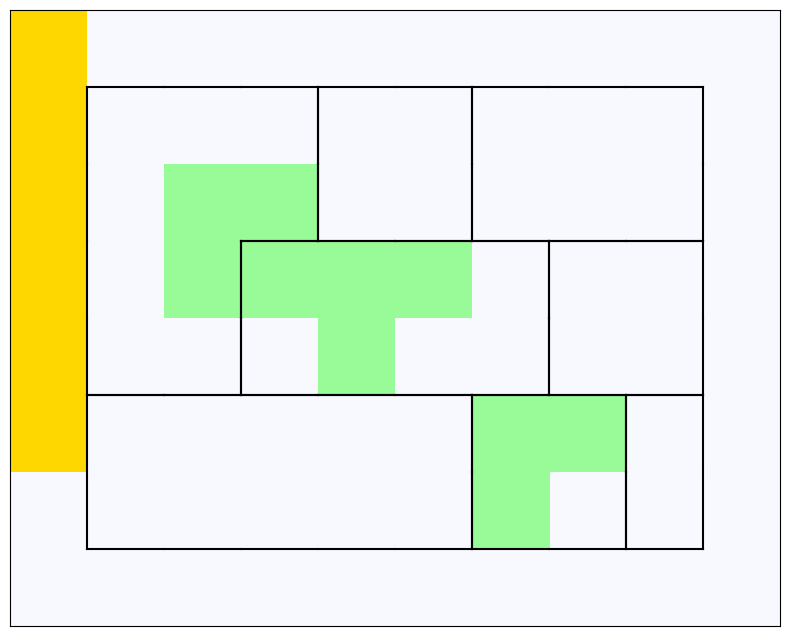

In [441]:
# Generar animación de la simulación inicial.

fig, axis = plt.subplots(figsize=(10, 8))
axis.set_xticks([])
axis.set_yticks([])

mycmap = matplotlib.colors.ListedColormap(['ghostwhite', 'turquoise', 'gold', 'yellowgreen', 'bisque', 'lightpink', 'mistyrose', 'palegreen'])

# patch = plt.imshow(all_grids.iloc[0, 0], cmap =mycmap)
# print(len(all_grids["WallGrid"][0][0]), len(all_grids["WallGrid"][0]))
extent = [-0.5, len(all_grids["WallGrid"][0][0]) - 0.5, -0.5, len(all_grids["WallGrid"][0]) - 0.5]

def animate(i):

  axis.clear()
  axis.set_xticks([])
  axis.set_yticks([])

  # Obtener el estado de las puertas en el paso actual

  # Dibujar paredes y puertas con el estado actual, incluyendo las entradas
  draw_walls(axis, all_grids["WallGrid"].iloc[i])
  

  # Mostrar los agentes
  axis.imshow(all_grids.iloc[i, 0], cmap=mycmap, interpolation="none", origin='upper', extent=extent)


anim = animation.FuncAnimation(fig, animate, frames = model.steps)
anim